In [2]:
from google.colab import drive
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
!pip install hmmlearn
!pip install fastdtw


    100% |████████████████████████████████| 153kB 13.2MB/s 
  Stored in directory: /root/.cache/pip/wheels/9a/a4/ee/917f0de81626b684fd2139ef5df47744c35ebeacc9e950487b
Successfully built hmmlearn


In [5]:
import os
import sys
import time
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.mixture import GaussianMixture as GMM
import matplotlib.pyplot as plt
from hmmlearn import hmm
from sklearn.model_selection import train_test_split
import matplotlib.style
import matplotlib as mpl
from sklearn.model_selection import cross_val_score, KFold
mpl.style.use('classic')
import tensorflow as tf
import itertools
from itertools import chain
import keras.backend as K
from sklearn.decomposition import PCA 
from keras.datasets import mnist
from sklearn.cluster import KMeans
import pickle
import collections
from sklearn.model_selection import GridSearchCV
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Flatten, add
from keras.layers import Conv2D, Dense, Activation, LeakyReLU
from keras.layers import Dropout, BatchNormalization, MaxPooling2D, AveragePooling2D
from keras.utils import np_utils, to_categorical
from keras.optimizers import SGD, Adam
from keras.regularizers import l2
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.constraints import nonneg
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sn
from scipy.spatial.distance import euclidean

from fastdtw import fastdtw


Using TensorFlow backend.


In [0]:
train_10 = np.load('/content/gdrive/My Drive/Project/Music Data/msd-10-genre-train.npz')
val_10 = np.load('/content/gdrive/My Drive/Project/Music Data/msd-10-genre-valid.npz')
num_classes = train_10['label_map'].shape[0]
X_train = train_10['inputs']
Y_train = train_10['targets']
X_test = val_10['inputs']
Y_test = val_10['targets']

X_train_mean = train_10['mean']
X_train_std = train_10['std']
X_train_std.shape


class_name = train_10['label_map']
label_name =np.array([x.decode() for x in class_name])

In [0]:
chroma = np.zeros((10,12))
mfcc = np.zeros((10,12))
x_train = np.zeros_like(X_train)
for i in range(0, X_train.shape[0]):
  x_train[i,:,:] =  np.multiply(X_train[i,:,:], X_train_std) + X_train_mean


for k in range(0, num_classes):
  if any(Y_train==k):
    x = x_train[Y_train==k]
    #print(x.shape)
    for j in range(0, x.shape[0]):
      #print(x[j,:,12:24].shape)
      chroma[k,:] = chroma[k,:] + np.mean(x[j,:,12:24], axis= 0)
      mfcc[k,:] = mfcc[k,:] + np.mean(x[j,:,0:12], axis= 0)

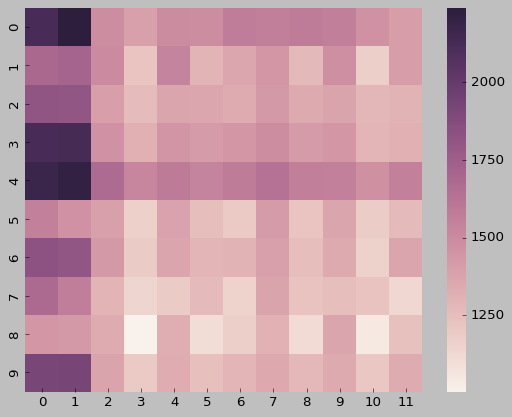

In [0]:
sn.heatmap(chroma)

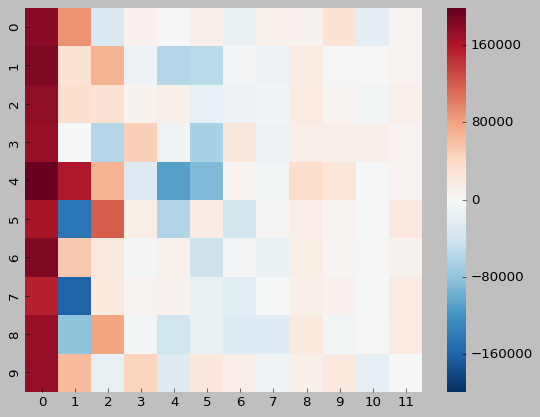

In [0]:
sn.heatmap(mfcc)

# Random Classification: Randomly pick a class where each class is equally likely

In [0]:
y_pred = np.random.randint(0,10, size = Y_test.shape[0])


In [0]:
acc_rand = accuracy_score(Y_test, y_pred)*100
print('Accuracy of random classification: %0.2f%%' % acc_rand)


Accuracy of random classification: 10.12%


# Train-val split

In [0]:
X_cv = np.copy(X_train)
Y_cv = np.copy(Y_train)
X_train, X_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.10)


In [0]:
def Metrics(preds, labs, show=True):
  """Print precision, recall and F1 for each language.
  Assumes a single language per example, i.e. no code switching.
  Args:
    preds: list of predictions
    labs: list of labels
    show: flag to toggle printing
  """
  all_langs = set(preds + labs)
  preds = np.array(preds)
  labs = np.array(labs)
  label_totals = collections.Counter(labs)
  pred_totals = collections.Counter(preds)
  confusion_matrix = collections.Counter(zip(preds, labs))
  num_correct = 0
  for lang in all_langs:
    num_correct += confusion_matrix[(lang, lang)]
  acc = num_correct / float(len(preds))
  print('accuracy = {0:.3f}'.format(acc))
  if show:
    print(' Lang     Prec.   Rec.   F1')
    print('------------------------------')
  scores = []
  fmt_str = '  {0:6}  {1:6.2f} {2:6.2f} {3:6.2f}'
  for lang in sorted(all_langs):
    idx = preds == lang
    total = max(1.0, pred_totals[lang])
    precision = 100.0 * confusion_matrix[(lang, lang)] / total
    idx = labs == lang
    total = max(1.0, label_totals[lang])
    recall = 100.0 * confusion_matrix[(lang, lang)] / total
    if precision + recall == 0.0:
      f1 = 0.0
    else:
      f1 = 2.0 * precision * recall / (precision + recall)
    scores.append([precision, recall, f1])
    if show:
      print(fmt_str.format(lang, precision, recall, f1))
  totals = np.array(scores).mean(axis=0)
  if show:
    print('------------------------------')
    print(fmt_str.format('Total:', totals[0], totals[1], totals[2]))
  return totals[2]


class MovingAvg(object):
  
  def __init__(self, p):
    self.val = None
    self.p = p

  def Update(self, v):
    if self.val is None:
      self.val = v
      return v
    self.val = self.p * self.val + (1.0 - self.p) * v
    return self.val

# GMM with all features: cross validation

In [0]:
x_cv = np.zeros((X_cv.shape[0], X_cv.shape[2]))
for i in range(0, X_cv.shape[0]):
  x_cv[i,:] = np.mean(X_cv[i,:,:], axis=0)

train_idx = []
val_idx = []
kf = KFold(n_splits=10)
for train_index, val_index in kf.split(x_cv):
  train_idx.append(train_index)
  val_idx.append(val_index)

In [0]:
train_idx = np.array(train_idx)
val_idx = np.array(val_idx)
print(train_idx.shape)
print(val_idx.shape)

(10, 36000)
(10, 4000)


In [0]:
accuracy = []
start_time = time.time()
for k in range(0, train_idx.shape[0]):

  x_train_cv = x_cv[train_idx[k,:]]
  y_train_cv = Y_cv[train_idx[k,:]]
  x_val_cv = x_cv[val_idx[k,:]]
  y_val_cv = Y_cv[val_idx[k,:]]
  
  mixtures = [GMM(n_components = 5, covariance_type = 'full', max_iter = 200, n_init=3) for k in range(0,num_classes)]
  for k, mix in enumerate(mixtures):
    if any(y_train_cv==k):
      mix.fit(x_train_cv[y_train_cv==k])

  ll_g1 = np.zeros((x_val_cv.shape[0], num_classes))

  for i in range(0, x_val_cv.shape[0]):
    for k, mix in enumerate(mixtures):

      ll_g1[i,k] = mix.score(x_val_cv[i,:].reshape(1,-1))

  ypred_gmm1 = np.argmax(ll_g1, axis=1)
  acc_gmm = accuracy_score(y_val_cv, ypred_gmm1)*100
  accuracy.append(acc_gmm)
  print('Accuracy of gmm validation: %0.2f%%' % acc_gmm)
    


Accuracy of gmm validation: 51.62%
Accuracy of gmm validation: 52.50%
Accuracy of gmm validation: 49.35%
Accuracy of gmm validation: 51.42%
Accuracy of gmm validation: 51.12%
Accuracy of gmm validation: 50.10%
Accuracy of gmm validation: 49.40%
Accuracy of gmm validation: 51.62%
Accuracy of gmm validation: 50.98%
Accuracy of gmm validation: 50.02%


TypeError: ignored

In [0]:
end_time = time.time()
print('Total time: ', end_time-start_time)

Total time:  500.3375766277313


In [0]:
print(accuracy)
filename = '/content/gdrive/My Drive/Project/gmm_all_feats.sav'
pickle.dump(mixtures, open(filename, 'wb'))


[51.87500000000001, 51.87500000000001, 49.75, 51.725, 51.475, 50.025, 50.3, 52.25, 50.875, 50.349999999999994]


In [0]:
x_test_cv = np.zeros((X_test.shape[0], X_test.shape[2]))
y_test_cv = np.copy(Y_test)

for i in range(0, X_test.shape[0]):
  x_test_cv[i,:] = np.mean(X_test[i,:,:], axis=0)

ll_g1_test = np.zeros((x_test_cv.shape[0], num_classes))

for i in range(0, x_test_cv.shape[0]):
  for k, mix in enumerate(mixtures):

    ll_g1_test[i,k] = mix.score(x_test_cv[i,:].reshape(1,-1))
    


In [0]:
mpl.style.use('seaborn-paper')
def plot_confusion_matrix(cm,target_names,title='Confusion matrix',cmap=None,normalize=True):
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    fig = plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=12)
    plt.colorbar()
    fig.set_facecolor('white')

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45, fontsize=12)
        plt.yticks(tick_marks, target_names,fontsize=12)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center", 
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    
    plt.show()

Accuracy of gmm test: 51.05%


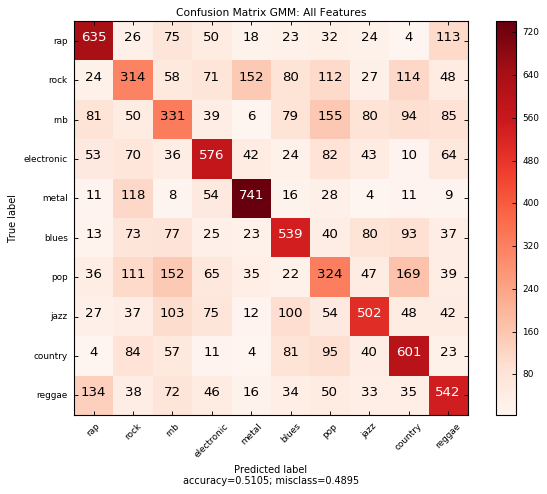

In [0]:
ypred_gmm1_test_cv = np.argmax(ll_g1_test, axis=1)
acc_gmm_test_cv = accuracy_score(y_test_cv, ypred_gmm1_test_cv)*100
print('Accuracy of gmm test: %0.2f%%' % acc_gmm_test_cv)

labels = class_name
cm = confusion_matrix(y_test_cv, ypred_gmm1_test_cv,labels =[0,1,2,3,4,5,6,7,8,9])
plot_confusion_matrix(cm,normalize = False,target_names = label_name,title = "Confusion Matrix GMM: All Features")


Accuracy of gmm test: 51.05%


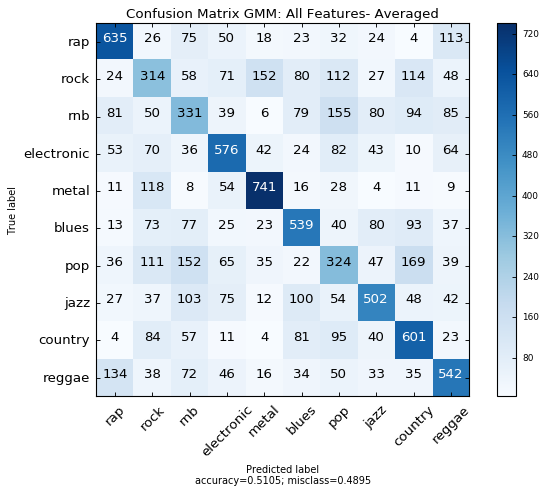

accuracy = 0.510
 Lang     Prec.   Rec.   F1
------------------------------
       0   62.38  63.50  62.93
       1   34.09  31.40  32.69
       2   34.16  33.10  33.62
       3   56.92  57.60  57.26
       4   70.64  74.10  72.33
       5   54.01  53.90  53.95
       6   33.33  32.40  32.86
       7   57.05  50.20  53.40
       8   50.98  60.10  55.16
       9   54.09  54.20  54.15
      10    0.00   0.00   0.00
      11    0.00   0.00   0.00
      12    0.00   0.00   0.00
      13    0.00   0.00   0.00
      14    0.00   0.00   0.00
      15    0.00   0.00   0.00
      16    0.00   0.00   0.00
      17    0.00   0.00   0.00
      18    0.00   0.00   0.00
------------------------------
  Total:   26.72  26.87  26.76


26.755656871522206

In [14]:
mixtures = pickle.load(open('/content/gdrive/My Drive/Project/gmm_all_feats.sav', 'rb'))
x_test_cv = np.zeros((X_test.shape[0], X_test.shape[2]))
y_test_cv = np.copy(Y_test)

for i in range(0, X_test.shape[0]):
  x_test_cv[i,:] = np.mean(X_test[i,:,:], axis=0)

ll_g1_test = np.zeros((x_test_cv.shape[0], num_classes))

for i in range(0, x_test_cv.shape[0]):
  for k, mix in enumerate(mixtures):

    ll_g1_test[i,k] = mix.score(x_test_cv[i,:].reshape(1,-1))
    

ypred_gmm1_test_cv = np.argmax(ll_g1_test, axis=1)
acc_gmm_test_cv = accuracy_score(y_test_cv, ypred_gmm1_test_cv)*100
print('Accuracy of gmm test: %0.2f%%' % acc_gmm_test_cv)

labels = class_name
cm = confusion_matrix(y_test_cv, ypred_gmm1_test_cv,labels =[0,1,2,3,4,5,6,7,8,9])
plot_confusion_matrix(cm,normalize = False,target_names = label_name,title = "Confusion Matrix GMM: All Features- Averaged")
Metrics(ypred_gmm1_test_cv,y_test_cv)


# GMM: using only timbre data

In [0]:
train_idx = []
val_idx = []
kf = KFold(n_splits=5)
X_copy = np.copy(X_train)
Y_copy = np.copy(Y_train)

for train_index, val_index in kf.split(X_copy):
  train_idx.append(train_index)
  val_idx.append(val_index)

train_idx = np.array(train_idx)
val_idx = np.array(val_idx)
print(train_idx.shape)
print(val_idx.shape)


(5, 32000)
(5, 8000)


In [0]:
accuracy_tim = []

start_time= time.time()
for k in range(0, train_idx.shape[0]):

  X_cv_tim = X_copy[train_idx[k,:]]
  y_cv_tim = Y_copy[train_idx[k,:]]
  x_val_tim = X_copy[val_idx[k,:]]
  y_val_tim = Y_copy[val_idx[k,:]]
  
  x_train_tim = np.zeros((X_cv_tim.shape[0]*20, 12))
  y_train_tim = np.zeros((y_cv_tim.shape[0]*20,))
  
  for i in range(0, X_cv_tim.shape[0]):
    for j in range(0, 20):
      x_train_tim[i*20 + j] = np.copy(X_cv_tim[i,j,0:12])
      y_train_tim[i*20 + j] = np.copy(y_cv_tim[i]) 
  
  mixtures = [GMM(n_components = 5, covariance_type = 'full', max_iter = 200, n_init=3) for k in range(0,num_classes)]
  for k, mix in enumerate(mixtures):
    if any(y_train_tim==k):
      mix.fit(x_train_tim[y_train_tim==k])

  ll_g1 = np.zeros((x_val_tim.shape[0], num_classes))

  for i in range(0, x_val_tim.shape[0]):
    for k, mix in enumerate(mixtures):
      score = np.zeros((20,))
      for j in range(0,20):
        vec = x_val_tim[i,j,0:12]
        score[j] = mix.score(vec.reshape(1,-1))
      ll_g1[i,k] = (1/20)*np.sum(score)

  ypred_tim = np.argmax(ll_g1, axis=1)
  acc_tim = accuracy_score(y_val_tim, ypred_tim)*100
  print('Accuracy of gmm validation: %0.2f%%' % acc_tim)

  end_time = time.time()
  print('Total time: ', end_time-start_time)

Accuracy of gmm validation: 41.80%
Total time:  557.5009117126465
Accuracy of gmm validation: 41.99%
Total time:  1098.9578347206116
Accuracy of gmm validation: 42.52%
Total time:  1623.6027963161469
Accuracy of gmm validation: 41.56%
Total time:  2148.2001078128815
Accuracy of gmm validation: 42.70%
Total time:  2673.0373754501343


In [0]:
print(accuracy_tim)
filename = '/content/gdrive/My Drive/Project/gmm_timbre.sav'
pickle.dump(mixtures, open(filename, 'wb'))

[]


In [0]:
ll_g1_tim = np.zeros((X_test.shape[0], num_classes))

for i in range(0, X_test.shape[0]):
  for k, mix in enumerate(mixtures):
    score = np.zeros((20,))
    for j in range(0,20):
      vec = X_test[i,j,0:12]
      score[j] = mix.score(vec.reshape(1,-1))
    ll_g1_tim[i,k] = (1/20)*np.sum(score)
   

Accuracy of gmm test: 41.93%


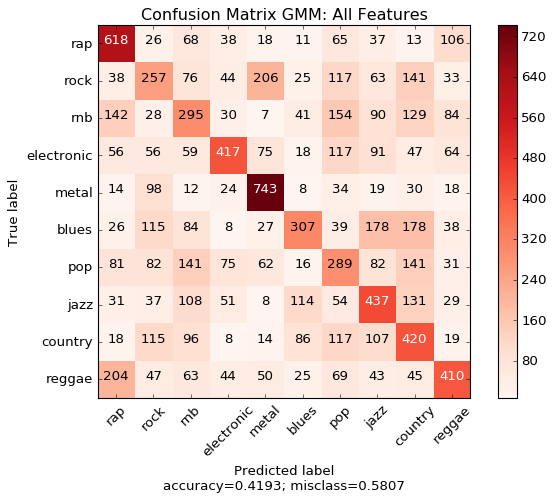

In [0]:
ypred_gmm1_test_tim = np.argmax(ll_g1_tim, axis=1)
acc_gmm_test_tim = accuracy_score(Y_test, ypred_gmm1_test_tim)*100
print('Accuracy of gmm test: %0.2f%%' % acc_gmm_test_tim)
labels = class_name
cm = confusion_matrix(Y_test, ypred_gmm1_test_tim,labels =[0,1,2,3,4,5,6,7,8,9])
plot_confusion_matrix(cm,normalize = False,target_names = label_name,title = "Confusion Matrix GMM: Timbre features")


Accuracy of gmm test: 41.93%


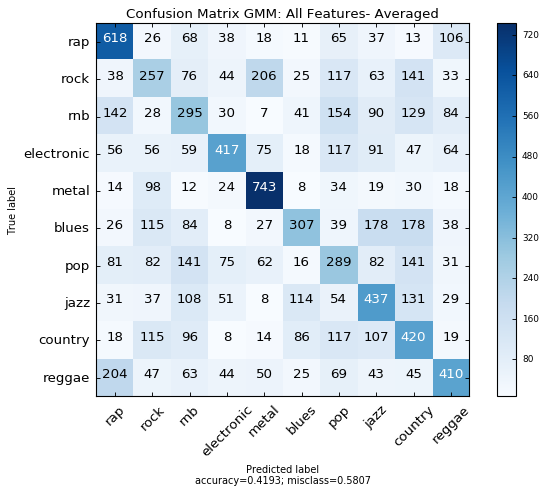

accuracy = 0.419
 Lang     Prec.   Rec.   F1
------------------------------
       0   50.33  61.80  55.48
       1   29.85  25.70  27.62
       2   29.44  29.50  29.47
       3   56.43  41.70  47.96
       4   61.40  74.30  67.24
       5   47.16  30.70  37.19
       6   27.39  28.90  28.13
       7   38.10  43.70  40.71
       8   32.94  42.00  36.92
       9   49.28  41.00  44.76
      10    0.00   0.00   0.00
      11    0.00   0.00   0.00
      12    0.00   0.00   0.00
      13    0.00   0.00   0.00
      14    0.00   0.00   0.00
      15    0.00   0.00   0.00
      16    0.00   0.00   0.00
      17    0.00   0.00   0.00
      18    0.00   0.00   0.00
------------------------------
  Total:   22.23  22.07  21.87


21.866907229881758

In [17]:
mixtures = pickle.load(open('/content/gdrive/My Drive/Project/gmm_timbre.sav', 'rb'))
ll_g1_tim_test = np.zeros((X_test.shape[0], num_classes))

for i in range(0, X_test.shape[0]):
  for k, mix in enumerate(mixtures):
    score = np.zeros((20,))
    for j in range(0,20):
      vec = X_test[i,j,0:12]
      score[j] = mix.score(vec.reshape(1,-1))
    ll_g1_tim_test[i,k] = (1/20)*np.sum(score)
    


Accuracy of gmm test: 41.93%


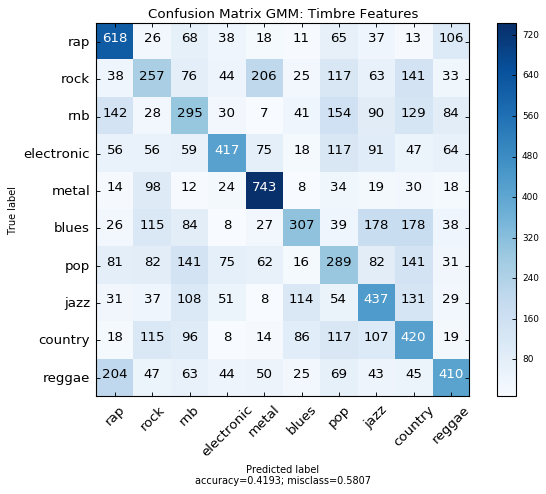

accuracy = 0.419
 Lang     Prec.   Rec.   F1
------------------------------
       0   50.33  61.80  55.48
       1   29.85  25.70  27.62
       2   29.44  29.50  29.47
       3   56.43  41.70  47.96
       4   61.40  74.30  67.24
       5   47.16  30.70  37.19
       6   27.39  28.90  28.13
       7   38.10  43.70  40.71
       8   32.94  42.00  36.92
       9   49.28  41.00  44.76
      10    0.00   0.00   0.00
      11    0.00   0.00   0.00
      12    0.00   0.00   0.00
      13    0.00   0.00   0.00
      14    0.00   0.00   0.00
      15    0.00   0.00   0.00
      16    0.00   0.00   0.00
      17    0.00   0.00   0.00
      18    0.00   0.00   0.00
------------------------------
  Total:   22.23  22.07  21.87


21.866907229881758

In [18]:

ypred_gmm1_test_cv = np.argmax(ll_g1_tim_test, axis=1)
acc_gmm_test_cv = accuracy_score(y_test_cv, ypred_gmm1_test_cv)*100
print('Accuracy of gmm test: %0.2f%%' % acc_gmm_test_cv)

labels = class_name
cm = confusion_matrix(y_test_cv, ypred_gmm1_test_cv,labels =[0,1,2,3,4,5,6,7,8,9])
plot_confusion_matrix(cm,normalize = False,target_names = label_name,title = "Confusion Matrix GMM: Timbre Features")
Metrics(ypred_gmm1_test_cv,y_test_cv)

In [0]:
Metrics(ypred_gmm1_test_tim, Y_test)

accuracy = 0.419
 Lang     Prec.   Rec.   F1
------------------------------
       0   50.33  61.80  55.48
       1   29.85  25.70  27.62
       2   29.44  29.50  29.47
       3   56.43  41.70  47.96
       4   61.40  74.30  67.24
       5   47.16  30.70  37.19
       6   27.39  28.90  28.13
       7   38.10  43.70  40.71
       8   32.94  42.00  36.92
       9   49.28  41.00  44.76
      10    0.00   0.00   0.00
      11    0.00   0.00   0.00
      12    0.00   0.00   0.00
      13    0.00   0.00   0.00
      14    0.00   0.00   0.00
      15    0.00   0.00   0.00
      16    0.00   0.00   0.00
      17    0.00   0.00   0.00
      18    0.00   0.00   0.00
------------------------------
  Total:   22.23  22.07  21.87


21.866907229881758

# Gaussian Mixture Model: using only pitch


In [0]:
train_idx = []
val_idx = []
kf = KFold(n_splits=5)
X_copy = np.copy(X_train)
Y_copy = np.copy(Y_train)

for train_index, val_index in kf.split(X_copy):
  train_idx.append(train_index)
  val_idx.append(val_index)

train_idx = np.array(train_idx)
val_idx = np.array(val_idx)
print(train_idx.shape)
print(val_idx.shape)

(5, 32000)
(5, 8000)


In [0]:
accuracy_p = []

start_time= time.time()
for k in range(0, train_idx.shape[0]):

  X_cv_p = X_copy[train_idx[k,:]]
  y_cv_p = Y_copy[train_idx[k,:]]
  x_val_p = X_copy[val_idx[k,:]]
  y_val_p = Y_copy[val_idx[k,:]]
  
  x_train_p = np.zeros((X_cv_p.shape[0]*20, 12))
  y_train_p = np.zeros((y_cv_p.shape[0]*20,))
  
  for i in range(0, X_cv_p.shape[0]):
    for j in range(0, 20):
      x_train_p[i*20 + j] = np.copy(X_cv_p[i,j,12:24])
      y_train_p[i*20 + j] = np.copy(y_cv_p[i]) 
  
  mixtures = [GMM(n_components = 5, covariance_type = 'full', max_iter = 200, n_init=3) for k in range(0,num_classes)]
  for k, mix in enumerate(mixtures):
    if any(y_train_p==k):
      mix.fit(x_train_p[y_train_p==k])

  ll_g1 = np.zeros((x_val_p.shape[0], num_classes))

  for i in range(0, x_val_p.shape[0]):
    for k, mix in enumerate(mixtures):
      score = np.zeros((20,))
      for j in range(0,20):
        vec = x_val_p[i,j,12:24]
        score[j] = mix.score(vec.reshape(1,-1))
      ll_g1[i,k] = (1/20)*np.sum(score)

  ypred_p = np.argmax(ll_g1, axis=1)
  acc_p = accuracy_score(y_val_p, ypred_p)*100
  print('Accuracy of gmm validation: %0.2f%%' % acc_p)

  end_time = time.time()
  print('Total time: ', end_time-start_time)

Accuracy of gmm validation: 27.80%
Total time:  509.67922353744507
Accuracy of gmm validation: 27.76%
Total time:  999.9622602462769
Accuracy of gmm validation: 27.22%
Total time:  1489.8237946033478
Accuracy of gmm validation: 27.15%
Total time:  1981.1424250602722
Accuracy of gmm validation: 27.39%
Total time:  2467.284193754196


In [0]:
print(accuracy_p)
filename = '/content/gdrive/My Drive/Project/gmm_pitch.sav'
pickle.dump(mixtures, open(filename, 'wb'))

[]


In [0]:
ll_g1_p = np.zeros((X_test.shape[0], num_classes))

for i in range(0, X_test.shape[0]):
  for k, mix in enumerate(mixtures):
    score = np.zeros((20,))
    for j in range(0,20):
      vec = X_test[i,j,0:12]
      score[j] = mix.score(vec.reshape(1,-1))
    ll_g1_p[i,k] = (1/20)*np.sum(score)
    

Accuracy of gmm test: 11.24%


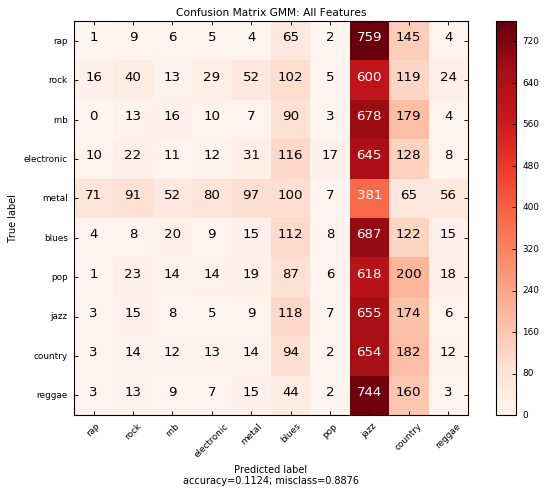

In [0]:
ypred_gmm1_test_p = np.argmax(ll_g1_p, axis=1)
acc_gmm_test_p = accuracy_score(Y_test, ypred_gmm1_test_p)*100
print('Accuracy of gmm test: %0.2f%%' % acc_gmm_test_p)
labels = class_name
cm = confusion_matrix(Y_test, ypred_gmm1_test_p,labels =[0,1,2,3,4,5,6,7,8,9])
plot_confusion_matrix(cm,normalize = False,target_names = label_name,title = "Confusion Matrix GMM: All Features")


In [0]:
Metrics(ypred_gmm1_test_p,Y_test,'True')

accuracy = 0.112
 Lang     Prec.   Rec.   F1
------------------------------
       0    0.89   0.10   0.18
       1   16.13   4.00   6.41
       2    9.94   1.60   2.76
       3    6.52   1.20   2.03
       4   36.88   9.70  15.36
       5   12.07  11.20  11.62
       6   10.17   0.60   1.13
       7   10.20  65.50  17.65
       8   12.35  18.20  14.71
       9    2.00   0.30   0.52
      10    0.00   0.00   0.00
      11    0.00   0.00   0.00
      12    0.00   0.00   0.00
      13    0.00   0.00   0.00
      14    0.00   0.00   0.00
      15    0.00   0.00   0.00
      16    0.00   0.00   0.00
      17    0.00   0.00   0.00
      18    0.00   0.00   0.00
------------------------------
  Total:    6.17   5.92   3.81


3.809073748784935

In [0]:
mixtures = pickle.load(open('/content/gdrive/My Drive/Project/gmm_pitch.sav', 'rb'))
ll_g1_p = np.zeros((X_test.shape[0], num_classes))

for i in range(0, X_test.shape[0]):
  for k, mix in enumerate(mixtures):
    score = np.zeros((20,))
    for j in range(0,20):
      vec = X_test[i,j,12:24]
      score[j] = mix.score(vec.reshape(1,-1))
    ll_g1_p[i,k] = (1/20)*np.sum(score)

Accuracy of gmm test: 27.03%


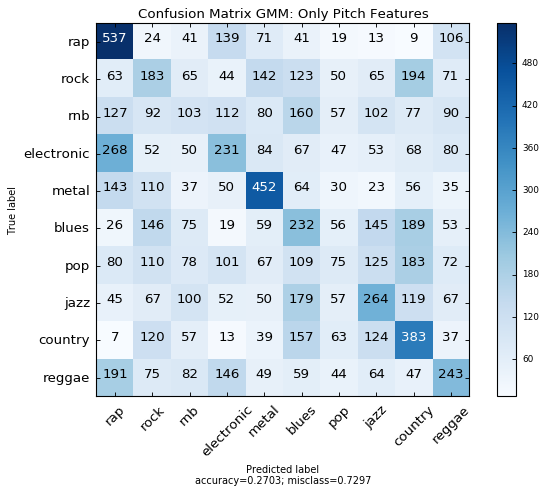

In [20]:
ypred_gmm1_test_p = np.argmax(ll_g1_p, axis=1)
acc_gmm_test_p = accuracy_score(Y_test, ypred_gmm1_test_p)*100
print('Accuracy of gmm test: %0.2f%%' % acc_gmm_test_p)
labels = class_name
cm = confusion_matrix(Y_test, ypred_gmm1_test_p,labels =[0,1,2,3,4,5,6,7,8,9])
plot_confusion_matrix(cm,normalize = False,target_names = label_name,title = "Confusion Matrix GMM: Only Pitch Features")

# GMM: all features: independent frames

In [0]:
train_idx = []
val_idx = []
kf = KFold(n_splits=5)
X_copy = np.copy(X_train)
Y_copy = np.copy(Y_train)

for train_index, val_index in kf.split(X_copy):
  train_idx.append(train_index)
  val_idx.append(val_index)

train_idx = np.array(train_idx)
val_idx = np.array(val_idx)
print(train_idx.shape)
print(val_idx.shape)

(5, 32000)
(5, 8000)


In [0]:
accuracy_tim = []

start_time= time.time()
for k in range(0, train_idx.shape[0]):

  X_cv = X_copy[train_idx[k,:]]
  y_cv = Y_copy[train_idx[k,:]]
  x_val = X_copy[val_idx[k,:]]
  y_val = Y_copy[val_idx[k,:]]
  
  x_train = np.zeros((X_cv.shape[0]*20, 25))
  y_train = np.zeros((y_cv.shape[0]*20,))
  
  for i in range(0, X_cv.shape[0]):
    for j in range(0, 20):
      x_train[i*20 + j] = np.copy(X_cv[i,j,:])
      y_train[i*20 + j] = np.copy(y_cv[i]) 
  
  mixtures = [GMM(n_components = 5, covariance_type = 'full', max_iter = 200, n_init=3) for k in range(0,num_classes)]
  for k, mix in enumerate(mixtures):
    if any(y_train==k):
      mix.fit(x_train[y_train==k])

  ll_g1 = np.zeros((x_val.shape[0], num_classes))

  for i in range(0, x_val.shape[0]):
    for k, mix in enumerate(mixtures):
      score = np.zeros((20,))
      for j in range(0,20):
        vec = x_val[i,j,:]
        score[j] = mix.score(vec.reshape(1,-1))
      ll_g1[i,k] = (1/20)*np.sum(score)

  ypred_gmm = np.argmax(ll_g1, axis=1)
  acc_gmm = accuracy_score(y_val, ypred_gmm)*100
  print('Accuracy of gmm validation: %0.2f%%' % acc_gmm)

  end_time = time.time()
  print('Total time: ', end_time-start_time)

Accuracy of gmm validation: 41.44%
Total time:  624.548415184021
Accuracy of gmm validation: 40.77%
Total time:  1255.4848392009735
Accuracy of gmm validation: 41.51%
Total time:  1937.045511007309
Accuracy of gmm validation: 40.64%
Total time:  2561.3198223114014
Accuracy of gmm validation: 41.76%
Total time:  3190.242434024811


In [0]:
print(accuracy_tim)
filename = '/content/gdrive/My Drive/Project/gmm_gmm2.sav'
pickle.dump(mixtures, open(filename, 'wb'))

[]


In [0]:
ll_g1 = np.zeros((X_test.shape[0], num_classes))

for i in range(0, X_test.shape[0]):
  for k, mix in enumerate(mixtures):
    score = np.zeros((20,))
    for j in range(0,20):
      vec = X_test[i,j,:]
      score[j] = mix.score(vec.reshape(1,-1))
    ll_g1[i,k] = (1/20)*np.sum(score)

Accuracy of gmm test: 40.67%


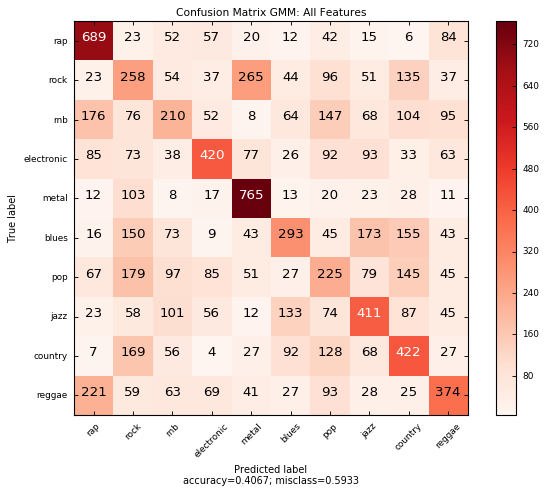

In [0]:
ypred_gmm1_test = np.argmax(ll_g1, axis=1)
acc_gmm_test = accuracy_score(Y_test, ypred_gmm1_test)*100
print('Accuracy of gmm test: %0.2f%%' % acc_gmm_test)
labels = class_name
cm = confusion_matrix(Y_test, ypred_gmm1_test,labels =[0,1,2,3,4,5,6,7,8,9])
plot_confusion_matrix(cm,normalize = False,target_names = label_name,title = "Confusion Matrix GMM: All Features")

In [0]:
Metrics(ypred_gmm1_test,Y_test,'True')

accuracy = 0.407
 Lang     Prec.   Rec.   F1
------------------------------
       0   52.24  68.90  59.42
       1   22.47  25.80  24.02
       2   27.93  21.00  23.97
       3   52.11  42.00  46.51
       4   58.44  76.50  66.26
       5   40.08  29.30  33.85
       6   23.39  22.50  22.94
       7   40.73  41.10  40.92
       8   37.02  42.20  39.44
       9   45.39  37.40  41.01
      10    0.00   0.00   0.00
      11    0.00   0.00   0.00
      12    0.00   0.00   0.00
      13    0.00   0.00   0.00
      14    0.00   0.00   0.00
      15    0.00   0.00   0.00
      16    0.00   0.00   0.00
      17    0.00   0.00   0.00
      18    0.00   0.00   0.00
------------------------------
  Total:   21.04  21.41  20.97


20.965481034619632

In [0]:
mixtures = pickle.load(open('/content/gdrive/My Drive/Project/gmm_gmm2.sav', 'rb'))
ll_g1 = np.zeros((X_test.shape[0], num_classes))

for i in range(0, X_test.shape[0]):
  for k, mix in enumerate(mixtures):
    score = np.zeros((20,))
    for j in range(0,20):
      vec = X_test[i,j,:]
      score[j] = mix.score(vec.reshape(1,-1))
    ll_g1[i,k] = (1/20)*np.sum(score)

Accuracy of gmm test: 40.67%


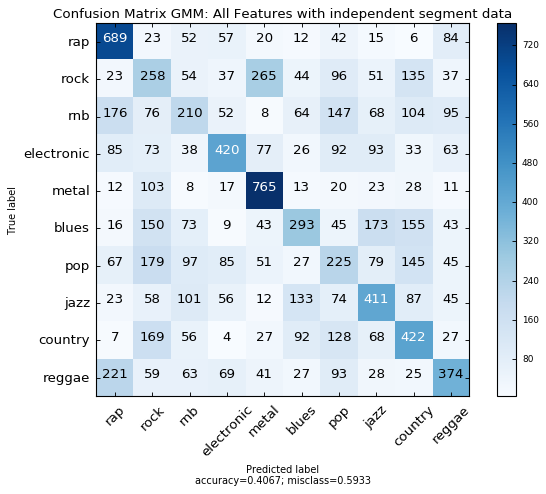

In [22]:
ypred_gmm1_test = np.argmax(ll_g1, axis=1)
acc_gmm_test = accuracy_score(Y_test, ypred_gmm1_test)*100
print('Accuracy of gmm test: %0.2f%%' % acc_gmm_test)
labels = class_name
cm = confusion_matrix(Y_test, ypred_gmm1_test,labels =[0,1,2,3,4,5,6,7,8,9])
plot_confusion_matrix(cm,normalize = False,target_names = label_name,title = "Confusion Matrix GMM: All Features with independent segment data")

# GMM with just loudness

In [0]:
x_cv_l = np.copy(X_cv[:,:,24]).reshape((X_cv.shape[0], X_cv.shape[1]))
# for i in range(0, X_cv.shape[0]):
#   x_cv_l[i,:] = np.mean(X_cv[i,:,24], axis=0)
train_idx = []
val_idx = []
kf = KFold(n_splits=10)

for train_index, val_index in kf.split(x_cv):
  train_idx.append(train_index)
  val_idx.append(val_index)

train_idx = np.array(train_idx)
val_idx = np.array(val_idx)
print(train_idx.shape)
print(val_idx.shape)

(10, 36000)
(10, 4000)


In [0]:
accuracy_l = []
for k in range(0, train_idx.shape[0]):

  x_train_l = x_cv_l[train_idx[k,:]]
  y_train_l = Y_cv[train_idx[k,:]]
  x_val_l = x_cv_l[val_idx[k,:]]
  y_val_l = Y_cv[val_idx[k,:]]
  
  
  mixtures = [GMM(n_components = 5, covariance_type = 'full', max_iter = 200, n_init=3) for k in range(0,num_classes)]
  for k, mix in enumerate(mixtures):
    if any(y_train_l==k):
      mix.fit(x_train_l[y_train_l==k])

  ll_g1 = np.zeros((x_val_l.shape[0], num_classes))

  for i in range(0, x_val_l.shape[0]):
    for k, mix in enumerate(mixtures):

      ll_g1[i,k] = mix.score(x_val_l[i,:].reshape(1,-1))

  ypred_l = np.argmax(ll_g1, axis=1)
  acc_l = accuracy_score(y_val_l, ypred_l)*100
  accuracy_l.append(acc_l)
  print('Accuracy of gmm validation: %0.2f%%' % acc_l)

KeyboardInterrupt: ignored

In [0]:
x_test_l = np.copy(X_test[:,:,24]).reshape((X_test.shape[0], X_cv.shape[1]))
y_test_l = np.copy(Y_test)

for i in range(0, X_test.shape[0]):
  x_test_l[i,:] = np.mean(X_test[i,:,12:24], axis=0)

ll_g1_l = np.zeros((x_test_l.shape[0], num_classes))

for i in range(0, x_test_l.shape[0]):
  for k, mix in enumerate(mixtures):

    ll_g1_l[i,k] = mix.score(x_test_l[i,:].reshape(1,-1))
    
ypred_gmm1_test_l = np.argmax(ll_g1_l, axis=1)
acc_gmm_test_l = accuracy_score(y_test_l, ypred_gmm1_test_l)*100
print('Accuracy of gmm test: %0.2f%%' % acc_gmm_test_l)
sn.heatmap(confusion_matrix(y_test_p,ypred_gmm1_test_l), annot=True, cmap='YlOrRd')
plt.title('Confusion Matrix for the ')

# Hidden Markov Model for timbre data



In [0]:
x_hmm_tim = np.zeros((X_cv.shape[0],12))
for i in range(0, X_cv.shape[0]):
  x_hmm_tim[i,:] = np.mean(X_cv[i,:,0:12], axis=0)

train_idx = []
val_idx = []
kf = KFold(n_splits=5)

for train_index, val_index in kf.split(x_hmm_tim):
  train_idx.append(train_index)
  val_idx.append(val_index)

train_idx = np.array(train_idx)
val_idx = np.array(val_idx)
print(train_idx.shape)
print(val_idx.shape)


(5, 32000)
(5, 8000)


In [0]:
accuracy_ht = []

start_time = time.time()
for k in range(0, train_idx.shape[0]):

  x_train_ht = x_hmm_tim[train_idx[k,:]]
  y_train_ht = Y_cv[train_idx[k,:]]
  x_val_ht = x_hmm_tim[val_idx[k,:]]
  y_val_ht = Y_cv[val_idx[k,:]]
  

  
  
  mixtures = [hmm.GMMHMM(n_components = 6, n_mix=3, covariance_type = 'full') for k in range(0,num_classes)]
  for k, mix in enumerate(mixtures):
    if any(y_train_ht==k):
      mix.fit(x_train_ht[y_train_ht==k])

  ll_g1 = np.zeros((x_val_ht.shape[0], num_classes))

  for i in range(0, x_val_ht.shape[0]):
    for k, mix in enumerate(mixtures):

      ll_g1[i,k] = mix.score(x_val_ht[i,:].reshape(1,-1))

  ypred_ht = np.argmax(ll_g1, axis=1)
  acc_ht = accuracy_score(y_val_ht, ypred_ht)*100
  accuracy_ht.append(acc_ht)
  print('Accuracy of hmm validation: %0.2f%%' % acc_ht)
  print(time.time()-start_time)
  
end_time = time.time()
print(end_time-start_time)

Accuracy of hmm validation: 34.24%
686.673691034317
Accuracy of hmm validation: 28.80%
1370.8972308635712
Accuracy of hmm validation: 27.85%
2055.696692466736
Accuracy of hmm validation: 28.76%
2752.362890481949
Accuracy of hmm validation: 30.24%
3448.839903354645
3448.8407757282257


In [0]:
x_test_ht = np.zeros((X_test.shape[0], 12))
y_test_ht = np.copy(Y_test)

for i in range(0, X_test.shape[0]):
  x_test_ht[i,:] = np.mean(X_test[i,:,0:12], axis=0)

ll_g1 = np.zeros((x_test_ht.shape[0], num_classes))

for i in range(0, x_test_ht.shape[0]):
  for k, mix in enumerate(mixtures):

    ll_g1[i,k] = mix.score(x_test_ht[i,:].reshape(1,-1))
    
ypred_test_ht = np.argmax(ll_g1, axis=1)
acc_test_ht = accuracy_score(y_test_ht, ypred_test_ht )*100
print('Accuracy of gmm test: %0.2f%%' % acc_test_ht)
sn.heatmap(confusion_matrix(y_test_ht,ypred_test_ht), annot=True, cmap='YlOrRd')
plt.title('Confusion Matrix for hmm')

# Simple 2 layer NN

In [0]:
X_train_rs = X_train.reshape((X_train.shape[0], X_train.shape[1]*X_train.shape[2]))
print(X_train_rs.shape)
X_val_rs = X_val.reshape((X_val.shape[0], X_val.shape[1]*X_val.shape[2]))
print(X_val_rs.shape)

(36000, 3000)
(4000, 3000)


In [0]:
model_name = 'simple_nn.h5'
input_shape = X_train_rs.shape[1:]

x_in = Input(shape=input_shape)

x = Dense(1000)(x_in)
x = Activation('relu')(x)
x = BatchNormalization()(x)

x = Dense(1000)(x)
x = Activation('relu')(x)
x = BatchNormalization()(x)

x_out = Dense(num_classes)(x)
# x = Dropout(0.5)(x)
x_out = Activation('softmax')(x)

model = Model(inputs=x_in, outputs=x_out)

model.summary()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics= ['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 3000)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 1000)              3001000   
_________________________________________________________________
activation_13 (Activation)   (None, 1000)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1000)              4000      
_________________________________________________________________
dense_14 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
activation_14 (Activation)   (None, 1000)              0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 1000)              4000      
__________

In [0]:
history = model.fit(X_train_rs, y_train, epochs = 20, batch_size=128, validation_data = (X_val_rs, y_val), verbose=1)
model.save('/content/gdrive/My Drive/Project/Music Data/'+model_name)

Train on 36000 samples, validate on 4000 samples
Epoch 1/20
36000/36000 [==============================] - 5s 144us/step - loss: 5.1891 - acc: 0.3907 - val_loss: 4.6403 - val_acc: 0.4675
Epoch 2/20
36000/36000 [==============================] - 4s 121us/step - loss: 3.8795 - acc: 0.5506 - val_loss: 3.7650 - val_acc: 0.4763
Epoch 3/20
36000/36000 [==============================] - 4s 121us/step - loss: 2.7040 - acc: 0.6716 - val_loss: 3.2884 - val_acc: 0.4700
Epoch 4/20
36000/36000 [==============================] - 4s 121us/step - loss: 1.7476 - acc: 0.7961 - val_loss: 3.1519 - val_acc: 0.4645
Epoch 5/20
36000/36000 [==============================] - 4s 121us/step - loss: 1.1389 - acc: 0.8731 - val_loss: 3.0187 - val_acc: 0.4505
Epoch 6/20
36000/36000 [==============================] - 4s 121us/step - loss: 0.8081 - acc: 0.9037 - val_loss: 2.9979 - val_acc: 0.4535
Epoch 7/20
36000/36000 [==============================] - 4s 120us/step - loss: 0.6212 - acc: 0.9197 - val_loss: 2.9898 - v

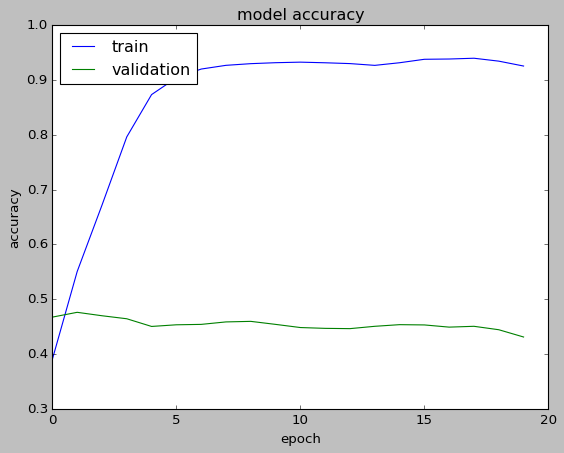

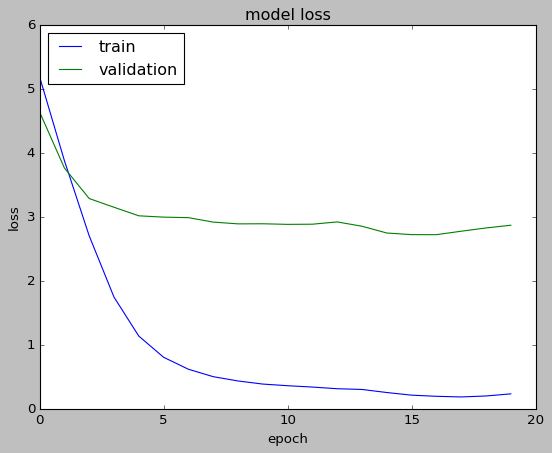

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()